# **Emotion Recognition from Facial Expressions - Using Deep Learning and Transfer Learning with PyTorch**
This notebook demonstrates the process of recognizing emotions from facial expressions using a deep learning approach with PyTorch. We'll use the FER2013 dataset for this task and a pre-trained VGG16 model.

**Steps Covered:**

1. **Loading the Dataset:**  Download and set up the FER2013 dataset.
1. **Data Preprocessing:** Prepare the dataset by resizing images and applying transformations.
1. **Visualizing the Data:** Display some sample images from the dataset.
1.**Model Architecture:** Use VGG16 as the base model, fine-tuned for emotion classification.
1. **Training:** Train the model on the FER2013 dataset.
1. **Evaluation:** Test the model's performance on the test set.
1. **Saving the Model:** Save the trained model for future use.

## Dataset Loading
We'll begin by downloading the FER2013 dataset from Kaggle.
To download the FER2013 dataset from Kaggle, you'll need to have your Kaggle API key set up. Follow these steps to configure your Kaggle API key:

1. Go to your Kaggle account settings at Kaggle Profile > Account.
1. Scroll down to the "API" section and click on **Create New API Token**. This will download a `kaggle.json`  file.
1. Upload this `kaggle.json` file

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d msambare/fer2013
! mkdir fer2013
! unzip fer2013.zip -d fer2013

Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer

##Data Preprocessing and Exploration

In [3]:
from pathlib import Path
import random
from PIL import Image
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
fer2013_path = Path("/content/fer2013")
train_data_path = fer2013_path / "train"
test_data_path = fer2013_path / "test"

fer2013_path, train_data_path, test_data_path

(PosixPath('/content/fer2013'),
 PosixPath('/content/fer2013/train'),
 PosixPath('/content/fer2013/test'))

In [5]:
train_images_list  = list(train_data_path.glob("*/*.jpg"))
test_images_list  = list(test_data_path.glob("*/*.jpg"))

print(f"Our dataset consists of {len(train_images_list) + len(test_images_list)} grayscale images, {len(train_images_list)} for training, and {len(test_images_list)} for testing. ")

Our dataset consists of 35887 grayscale images, 28709 for training, and 7178 for testing. 


Image name: Training_24149576, image class: sad, image height: 48, image width: 48


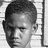

In [6]:
random_image_path = random.choice(train_images_list + test_images_list)

random_image = Image.open(random_image_path)

print(f"Image name: {random_image_path.stem}, image class: {random_image_path.parent.stem}, image height: {random_image.height}, image width: {random_image.width}")
random_image

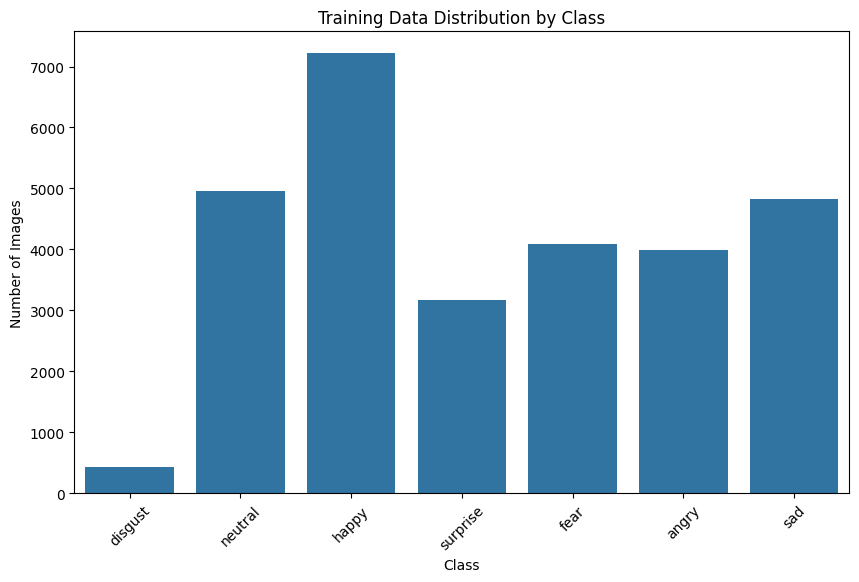

In [7]:
class_names = [path.name for path in train_data_path.glob("*") if path.is_dir()]
class_counts = [len(list((train_data_path / class_name).glob("*.jpg"))) for class_name in class_names]

df = pd.DataFrame({"Class": class_names, "Number of Images": class_counts})
plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Number of Images", data=df)
plt.title("Training Data Distribution by Class")
plt.xticks(rotation=45)
plt.show()

###Image Transformations and Normalization

We resize the images to 224x224 pixels and apply standard normalization to match the format required by the VGG16 model.

In [8]:
train_data = ImageFolder(
    root=train_data_path,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Removed the extra bracket here
    ])
)


test_data = ImageFolder(
    root = test_data_path,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
                                              )

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 28709
     Root location: /content/fer2013/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 7178
     Root location: /content/fer2013/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [9]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [10]:
print(f"Training classes: {train_data.classes}")
print(f"Testing classes: {test_data.classes}")

Training classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Testing classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


###DataLoader

In [11]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset= train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
    )

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size  = BATCH_SIZE,
    shuffle = False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fa068f9fdc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa068f9dba0>)

###Visualizing Training Batch Samples

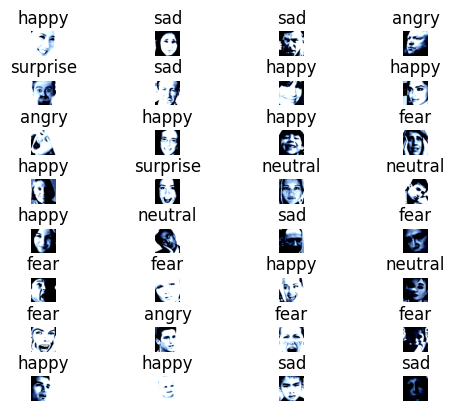

In [12]:
image_batch_features_sample , image_batch_labels_sample = next(iter(train_dataloader))


fig, axes = plt.subplots(nrows=8, ncols=4)
img_num = 0
for i in range(8):
  for j in range(4):
    if img_num < len(image_batch_features_sample):
      axes[i, j].imshow(image_batch_features_sample[img_num].permute(1,2,0))
      axes[i, j].set_title(train_data.classes[image_batch_labels_sample[img_num]])
      axes[i, j].axis('off')
      img_num += 1
    else:
      axes[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=1)
plt.show()

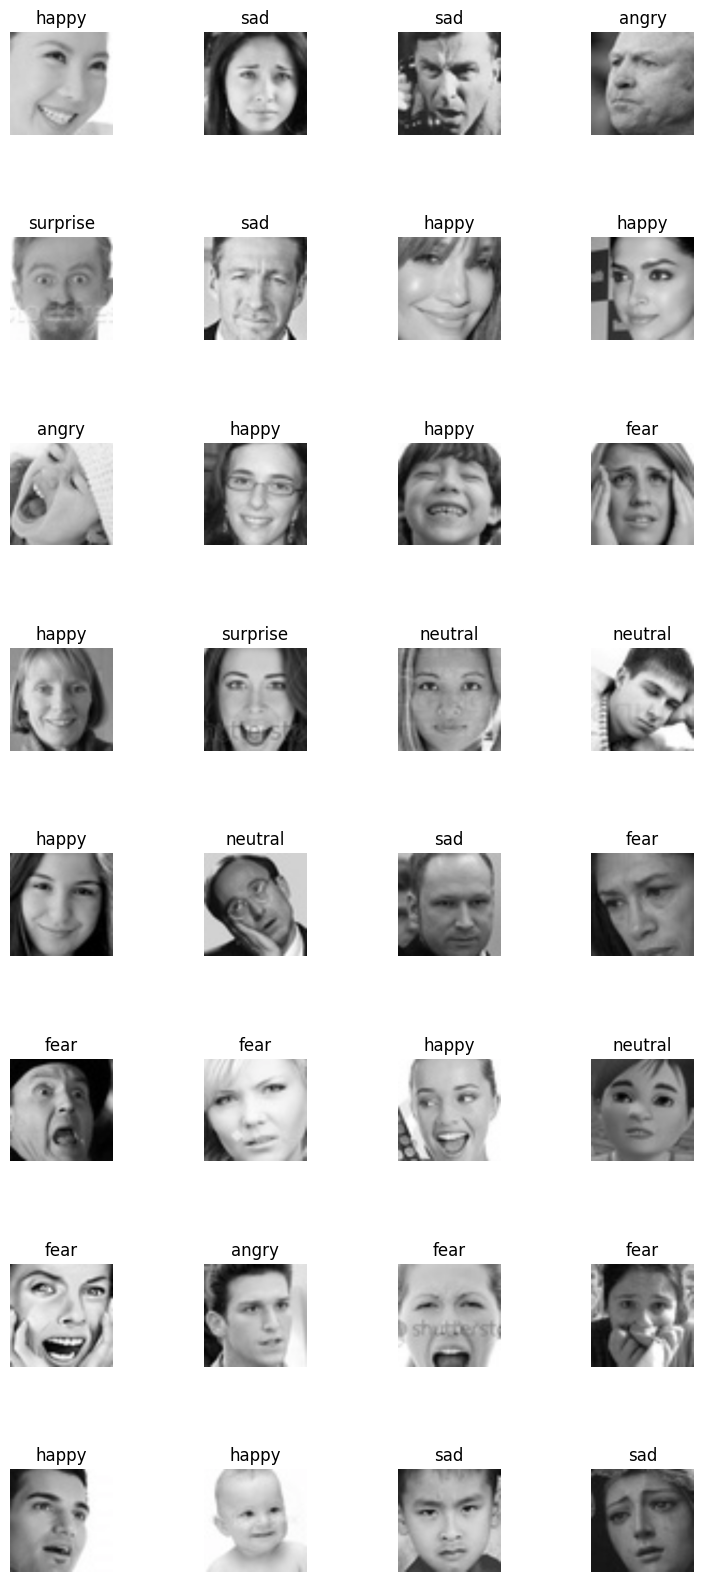

In [13]:
def unnormalize_image(image, mean, std):
    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    return (image * std) + mean

unnormalized_images = unnormalize_image(image_batch_features_sample, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(10, 20))
img_num = 0
for i in range(8):
    for j in range(4):
        if img_num < len(unnormalized_images):
            axes[i, j].imshow(unnormalized_images[img_num].permute(1, 2, 0).numpy())
            axes[i, j].set_title(train_data.classes[image_batch_labels_sample[img_num]])
            axes[i, j].axis('off')
            img_num += 1
        else:
            axes[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=1)
plt.show()

##Model Architecture

We chose VGG16 because it's a widely-used convolutional neural network architecture pre-trained on ImageNet. Using a pre-trained model allows us to leverage existing learned features, reducing training time and improving performance. We'll fine-tune the model by modifying the classifier to output 7 classes (corresponding to the emotions in the FER2013 dataset).

In [14]:
! pip install torchinfo

In [15]:
from torchvision import models
import torch.nn as nn
import torchinfo
from torchinfo import summary

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, 7)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 57.3MB/s]


In [17]:
summary(model,input_size=[32,3,224,224])

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 7]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]   

##Training the Model

In this section, we'll train our VGG16-based emotion recognition model using the **cross-entropy loss function** and the **Adam optimizer**. The training process will involve feeding batches of images through the model, computing the loss, and adjusting model weights using backpropagation. Both training and validation accuracy will be tracked to monitor performance over each epoch.

We will visualize the **training curves** at the end to help evaluate the model’s learning progress, including both **loss** and **accuracy** metrics for the training and validation sets.


In [18]:
from tqdm.auto import tqdm

In [19]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [21]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

We'll now train the model using the cross-entropy loss function and the Adam optimizer.

In [22]:
NUM_EPOCHS = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001)
model = model.to(device)
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6578 | train_acc: 0.3884 | test_loss: 1.4428 | test_acc: 0.4819
Epoch: 2 | train_loss: 1.4993 | train_acc: 0.4465 | test_loss: 1.3707 | test_acc: 0.5308
Epoch: 3 | train_loss: 1.4311 | train_acc: 0.4768 | test_loss: 1.2960 | test_acc: 0.5296
Epoch: 4 | train_loss: 1.3656 | train_acc: 0.4986 | test_loss: 1.2800 | test_acc: 0.5153
Epoch: 5 | train_loss: 1.3307 | train_acc: 0.5163 | test_loss: 1.2564 | test_acc: 0.5345
Epoch: 6 | train_loss: 1.3098 | train_acc: 0.5267 | test_loss: 1.2541 | test_acc: 0.5462
Epoch: 7 | train_loss: 1.2652 | train_acc: 0.5410 | test_loss: 1.2441 | test_acc: 0.5434
Epoch: 8 | train_loss: 1.2299 | train_acc: 0.5603 | test_loss: 1.2278 | test_acc: 0.5587
Epoch: 9 | train_loss: 1.2040 | train_acc: 0.5677 | test_loss: 1.2059 | test_acc: 0.5605
Epoch: 10 | train_loss: 1.1896 | train_acc: 0.5744 | test_loss: 1.1889 | test_acc: 0.5656
Epoch: 11 | train_loss: 1.1621 | train_acc: 0.5895 | test_loss: 1.2127 | test_acc: 0.5502
Epoch: 12 | train_l

- **Training Progress**: The training loss decreased consistently over the epochs, indicating that the model is learning. The training accuracy increased from **38.84%** to **62.61%**, showing improvement in the model's ability to classify the training data correctly.
  
- **Testing Performance**: The test loss fluctuated initially but showed an overall decreasing trend, with the test accuracy rising from **48.19%** to **58.44%**. This indicates that the model is generalizing better over time, although there are some fluctuations in performance.

The model could be trained further to enhance performance; however, due to limited computational resources, this may not be feasible.

After training, we'll visualize both the loss and accuracy curves for the training and validation sets. These plots help identify trends such as overfitting (when training accuracy is high but validation accuracy is low) or underfitting (when both accuracies are low).

Ideally, the **training loss** and **validation loss** should decrease over time, and the **accuracy** should increase. Large discrepancies between training and validation metrics can indicate the need for tuning or regularization techniques.


In [23]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """


    loss = results['train_loss']
    test_loss = results['test_loss']


    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    #loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    #accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


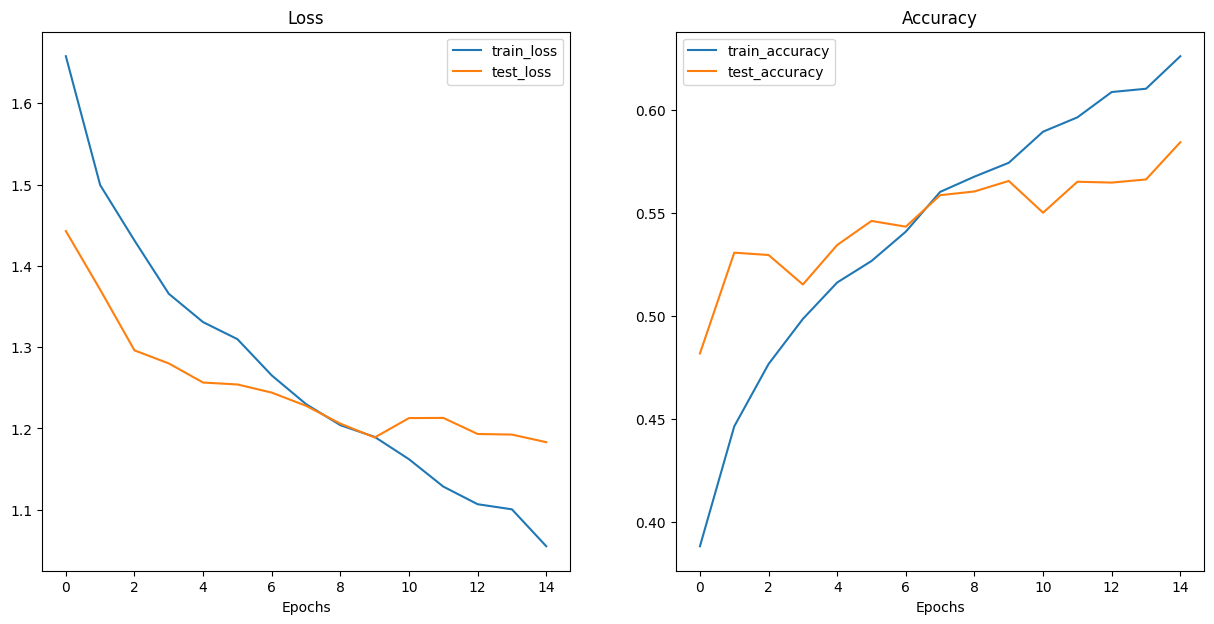

In [25]:
plot_loss_curves(model_results)

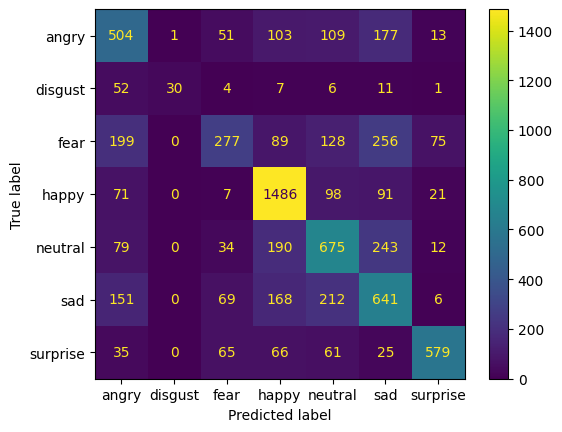

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot()
plt.show()


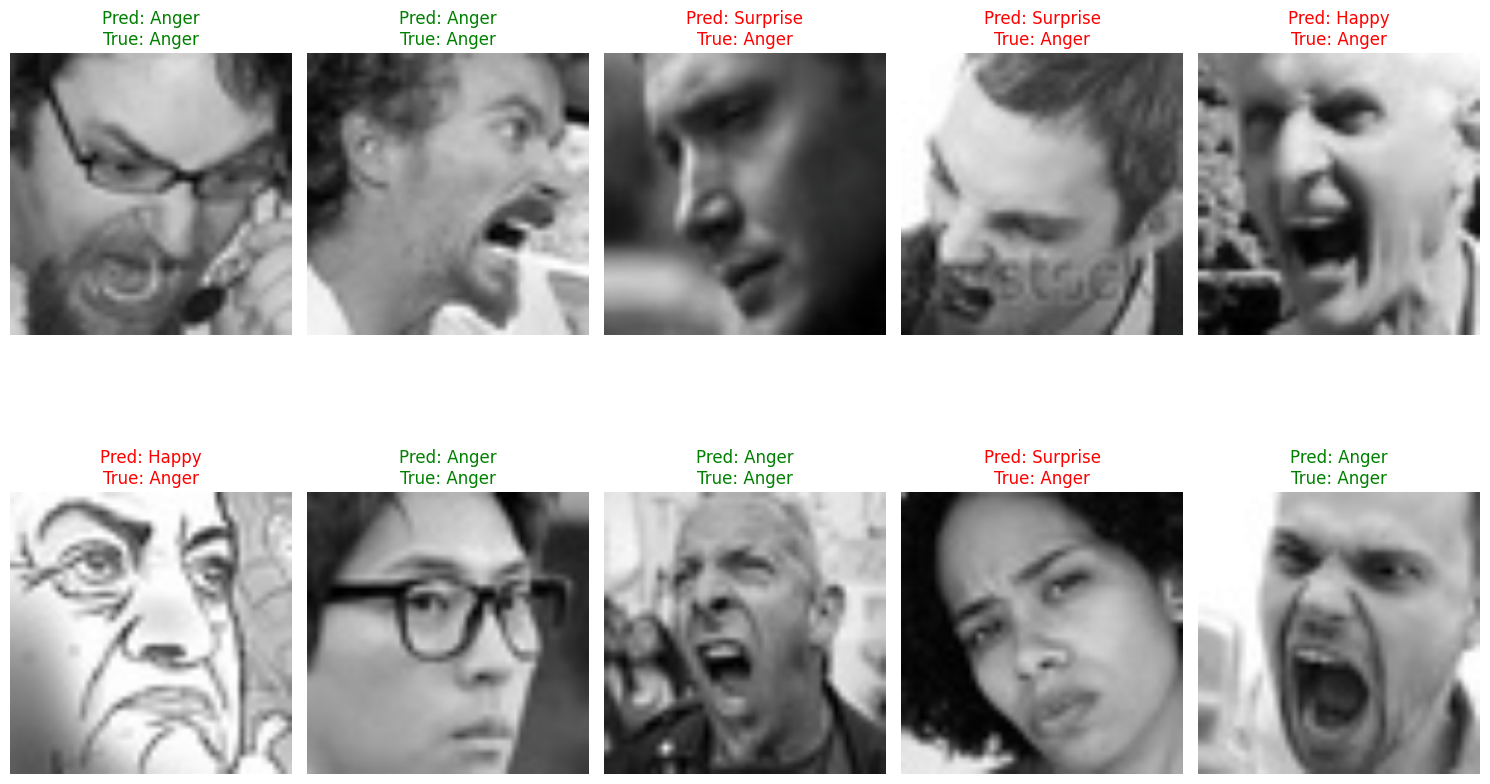

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor image.

    Args:
        tensor (torch.Tensor): The input tensor to denormalize.
        mean (list): The mean values used for normalization.
        std (list): The standard deviation values used for normalization.

    Returns:
        torch.Tensor: The denormalized tensor.
    """
    device = tensor.device
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(device)

    denormalized = tensor * std + mean
    denormalized = torch.clamp(denormalized, 0, 1)

    return denormalized

def plot_test_predictions(model, dataloader, device, class_names, num_images=10):
    """
    Plots a few images from the test set along with their predicted labels.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the test set.
        device (torch.device): The device to run the model on (CPU or GPU).
        class_names (list): List of class names corresponding to the output classes.
        num_images (int): Number of images to plot.
    """
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    images = denormalize(images, mean, std)

    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))

        color = 'green' if preds[i] == labels[i] else 'red'

        plt.title(f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plot_test_predictions(model, test_dataloader, device, class_names, num_images=10)


##Saving the Trained Model

In [31]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), '/content/drive/MyDrive/EmotionRecognition.pth')

Mounted at /content/drive
